# Magnetics - Directional derivatives, ASA and ASA2-PVD filtering
#### as part of worked filters in NFIS PROJECT - CPRM-UFPR 
#### CPRM Intern researcher: Luizemara S. A. Szameitat (luizemara@gmail.com)

Notebook from https://github.com/lszam/cprm-nfis.
Last modified: Dec/2021
___
○ References:
Richard Blakely (1996). Potential Theory in Gravity & Magnetic Applications.


FORMATO DO GRID DE ENTRADA:  
O dado precisa ser um array de duas dimensões, com nós das células nesta ordem: de oeste para leste, e de sul para norte.

In [1]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt
import matplotlib.pyplot as plt
import seaborn as sb

##### Functions

In [2]:
def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Kvalue(i, j, nx, ny, dkx, dky)
    adapted from Blakely (1996)
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1  
    kx = float() 
    ky = float() 
    if j <= nyqx:
        kx = (j-1) * dkx 
    else:
        kx = (j-nx-1) * dkx 
    if i <= nyqy:
        ky = (i-1) * dky 
    else:
        ky = (i-ny-1) * dky 
    return kx, ky

def go_filter(grid, filter_type, nx, ny, dkx, dky):
    '''
    Potential Field's filtering routines
    '''
    # FFT
    gridfft = scipy.fftpack.fft2(grid)
    # From matrix to vector
    gridfft = np.reshape(gridfft, nx*ny)  
    # Creating complex vector
    gridfft_filt = np.zeros(nx*ny).astype(complex)
    # Filtering 
    if filter_type == 'dz1':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = sqrt(kx**2 + ky**2)
                gridfft_filt[ij-1] = gridfft[ij-1]*k**1 #filtering expression
    elif filter_type == 'dy1':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i 
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)  
                k = kx                 
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1) 
    elif filter_type == 'dx1':       
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i 
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)  
                k = ky      
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)       
    else:
        return print ('Not supported filter_type=', filter_type) 
    
    #Return to matrix
    gridfft_filt = np.reshape(gridfft_filt, (ny, nx)) 
    #iFFT
    gridfft_filt = scipy.fftpack.ifft2(gridfft_filt)
    grid_out = np.reshape(gridfft_filt.real, (ny, nx)) 
    
    return grid_out

### Input data

In [3]:
# XYZ grid reading (CSV format, no header, no line numbers)
filename = 'https://raw.githubusercontent.com/lszam/cprm-nfis/main/data/pentanomaly.csv'

#reading csv columns - coordinates and physical property
csv_values = np.genfromtxt(filename, delimiter=",") #choose the delimiter
x = csv_values[:,0]
y = csv_values[:,1]
z = csv_values[:,2]

In [4]:
#Getting x and y values as lists
xnodes=[]
ynodes=[]
[xnodes.append(item) for item in x if not xnodes.count(item)]
[ynodes.append(item) for item in y if not ynodes.count(item)]

# Meshgrids of X and Y
xgrid, ygrid = np.meshgrid(xnodes, ynodes)

#Number of items in x and y directions
nx = np.size(xgrid,1)
ny = np.size(ygrid,0)

#Arranging the physical property into a matrix 
Z = np.array(z) # data from list to array 
grid_tfa = np.reshape(Z, (ny, nx))  
dX, dY = np.abs(xnodes[0]-xnodes[1]), np.abs(ynodes[0]-ynodes[1]) # cell size

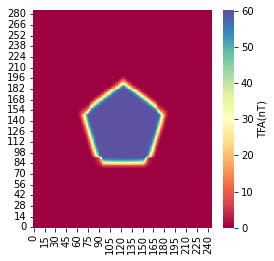

In [5]:
#Plot input data
plt.figure(figsize=(4, 4))
sb_plot2 = sb.heatmap(grid_tfa, cmap="Spectral", cbar_kws={'label': 'TFA(nT)'})
sb_plot2.invert_yaxis()

### Derivatives

In [6]:
π = np.pi
dkx = 2. * π / (nx * dX)
dky = 2. * π / (ny * dY)

# Filtering
gridX = go_filter(grid_tfa, 'dx1', nx, ny, dkx, dky)
gridY = go_filter(grid_tfa, 'dy1', nx, ny, dkx, dky)
gridZ = go_filter(grid_tfa, 'dz1', nx, ny, dkx, dky)

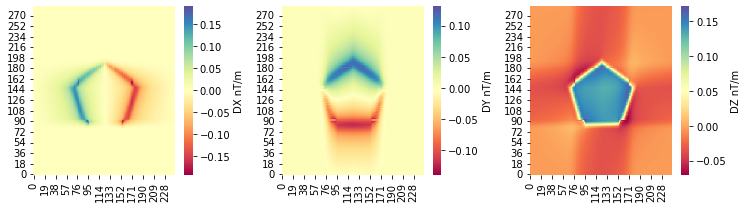

In [7]:
# Plot
plt.figure(figsize=(10.5, 3)) 
plt.subplot(1, 3, 1)
sb_plot1 = sb.heatmap(gridX, cmap="Spectral", cbar_kws={'label': 'DX nT/m'})
sb_plot1.invert_yaxis()
plt.subplot(1, 3, 2)
sb_plot2 = sb.heatmap(gridY, cmap="Spectral", cbar_kws={'label': 'DY nT/m'})
sb_plot2.invert_yaxis()
plt.subplot(1, 3, 3)
sb_plot3 = sb.heatmap(gridZ, cmap="Spectral", cbar_kws={'label': 'DZ nT/m'})
sb_plot3.invert_yaxis()
plt.tight_layout()

### ASA filter

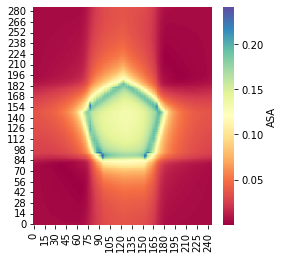

In [8]:
# ASA filter
'''
Analytic signal amplitude (ASA) 
'''  
grid_asa = np.sqrt((gridX**2)+(gridY**2)+(gridZ**2))

# Plot
plt.figure(figsize=(4, 4))
sb_plot2 = sb.heatmap(grid_asa, cmap="Spectral", cbar_kws={'label': 'ASA'})
sb_plot2.invert_yaxis()

### Pseudo-vertical derivative of the squared ASA (ASA2-PVD) 

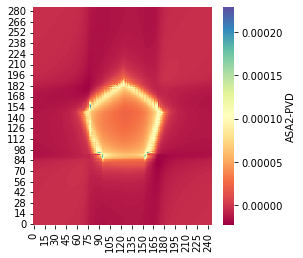

In [9]:
grid_asa2pvd = go_filter(grid_asa**2, 'dz1', nx, ny, dkx, dky)

# Plot
plt.figure(figsize=(4, 4))
sb_plot2 = sb.heatmap(grid_asa2pvd, cmap="Spectral", cbar_kws={'label': 'ASA2-PVD'})
sb_plot2.invert_yaxis()

In [10]:
#Save results as txt file
grid_output = np.reshape(grid_asa2pvd, ny*nx)
np.savetxt(str('asa2pvd.xyz'),np.c_[x,y,grid_output])